# Importowanie Bibliotek
Import niezbędnych bibliotek: TensorFlow, Keras, NumPy, Pandas oraz bibliotek do przetwarzania danych.

Do realizacji projektu użyto kluczowych bibliotek:
- TensorFlow i Keras: Do tworzenia, trenowania i oceny modelu sieci neuronowych.
- Pandas: Do manipulacji i analizy danych.
- Scikit-learn: Do normalizacji danych, kodowania etykiet oraz podziału na zbiory treningowe i testowe.
- Matplotlib i Seaborn: Do wizualizacji wyników, w tym macierzy pomyłek i wykresów uczenia.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Przygotowanie Danych
Wczytanie i przygotowanie danych treningowych, normalizacja danych, podział na zbiór treningowy i testowy.

### Wczytywanie danych
Dane wczytano z pliku CSV zawierającego parametry piwa:

- Wybrane cechy (kolumny):
  - Size(L), OG (Początkowa Gęstość), FG (Końcowa Gęstość), ABV (Zawartość alkoholu), IBU (Goryczka), Color, BoilSize, BoilTime, BoilGravity, Efficiency.
- Przygotowanie danych:
  - Uzupełniono brakujące wartości średnimi w kolumnach (X.fillna(X.mean())).
  - Dane zostały znormalizowane przy użyciu StandardScaler w celu poprawy wydajności modelu.
### Kodowanie etykiet
Styl piwa (Style) zakodowano do formatów numerycznych za pomocą LabelEncoder, a następnie przekształcono na reprezentację kategoryczną (to_categorical).

### Podział danych
Dane podzielono na:
- Zbiór treningowy: 80% próbek.
- Zbiór testowy: 20% próbek.

In [2]:
data = pd.read_csv('../data.csv')

numeric_columns = ['Size(L)',
                    'OG',
                    'FG',
                    'ABV',
                    'IBU',
                    'Color',
                    'BoilSize',
                    'BoilTime',
                    'BoilGravity',
                    'Efficiency'
                    ]
X = data[numeric_columns].copy()

X = X.fillna(X.mean())

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Style'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print("Kształt danych treningowych", X_train.shape)
print("Kształt danych testowych", X_test.shape)
print("Kształt etykiet treningowych", y_train.shape)
print("Kształt etykiet testowych", y_test.shape)

Kształt danych treningowych (59088, 10)
Kształt danych testowych (14773, 10)
Kształt etykiet treningowych (59088, 176)
Kształt etykiet testowych (14773, 176)


# Utworzenie Modelu Sequential
Zdefiniowanie architektury modelu sekwencyjnego z warstwami Dense, określenie liczby neuronów i funkcji aktywacji.

### Struktura modelu
Zbudowano model sekwencyjny z następującymi warstwami:
- Warstwa wejściowa: 256 neuronów z aktywacją ReLU.
- Warstwy ukryte: Trzy warstwy z 128, 64 i 32 neuronami, każda z aktywacją ReLU.
- Batch Normalization: Stabilizuje proces uczenia przez normalizację wsadową.
- Dropout: Regularizacja (50%) zapobiegająca przeuczeniu.
- Warstwa wyjściowa: 176 neuronów (liczba klas) z aktywacją softmax.
### Kompilacja modelu
- Optymalizator: Adam (szybkość uczenia = 0.001).
- Funkcja straty: categorical_crossentropy.
- Metryka: accuracy.

In [3]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

d:\Anaconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 176)            │         5,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,776 (210.06 KB)

 Trainable params: 52,816 (206.31 KB)

 Non-trainable params: 960 (3.75 KB)

# Trenowanie Modelu
Trenowanie modelu na danych treningowych z określoną liczbą epok i rozmiarem batcha.

### Proces uczenia
- Model trenowano przez maksymalnie 100 epok z batch size = 16.
- Dodano callbacki:
  - EarlyStopping: Przerywa trening, gdy strata walidacji przestaje się poprawiać.
  - ReduceLROnPlateau: Zmniejsza szybkość uczenia przy braku poprawy.
### Wyniki uczenia
- Dokładność walidacji po treningu: 32%.
- Strata walidacji: 2.78.
### Wizualizacja procesu uczenia
- Wykresy pokazują zmiany dokładności i straty na zbiorach treningowych i walidacyjnych.

Epoch 1/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.1571 - loss: 4.2521 - val_accuracy: 0.2533 - val_loss: 3.1869 - learning_rate: 0.0010
Epoch 2/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2209 - loss: 3.4092 - val_accuracy: 0.2815 - val_loss: 3.0520 - learning_rate: 0.0010
Epoch 3/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2359 - loss: 3.2951 - val_accuracy: 0.2923 - val_loss: 2.9870 - learning_rate: 0.0010
Epoch 4/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2364 - loss: 3.2693 - val_accuracy: 0.2926 - val_loss: 2.9575 - learning_rate: 0.0010
Epoch 5/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2362 - loss: 3.2254 - val_accuracy: 0.2879 - val_loss: 2.9443 - learning_rate: 0.0010
Epoch 6/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2420 - loss: 3.2005 - val_accuracy: 0.2958 - val_loss: 2.9236 - learning_rate: 0.0010
Epoch 7/100
2955/2955 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.

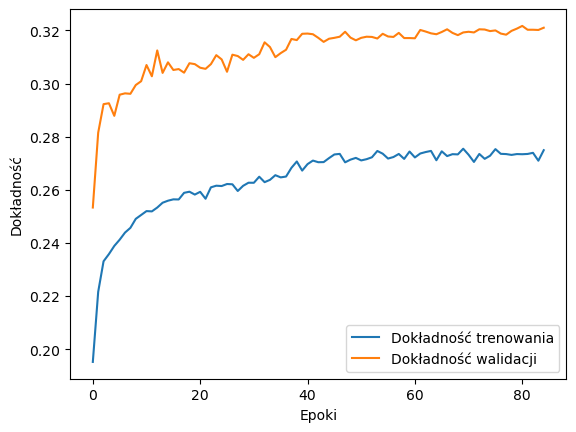

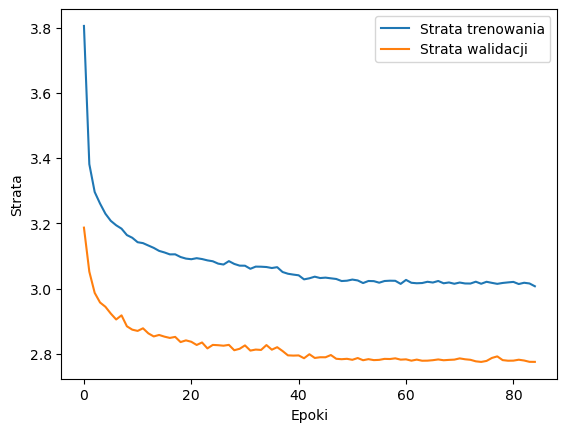

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = model.fit(X_train, 
                    y_train, 
                    epochs=100, 
                    batch_size=16, 
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

plt.plot(history.history['accuracy'], label='Dokładność trenowania')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Strata trenowania')
plt.plot(history.history['val_loss'], label='Strata walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()
plt.show()

# Testowanie i Ewaluacja
Ocena skuteczności modelu na zbiorze testowym i wyświetlenie metryk wydajności.

### Ocena modelu
- Model oceniono na zbiorze testowym, mierząc stratę i dokładność.
- Wynik: Dokładność klasyfikacji wyniosła 33%, a strata 2.73.
### Predykcje
- Przewidywania generowano dla każdej próbki testowej.
- Wybrano klasy z najwyższym prawdopodobieństwem.
### Analiza wyników
- Sprawdzono unikalne klasy w danych testowych.
- Wygenerowano raport klasyfikacji z precyzją, czułością i wynikiem F1.
- Stworzono macierz pomyłek, która została przedstawiona w formie graficznej.
### Macierz pomyłek
- Przedstawia, jak model myli się między klasami. Wyraźne problemy z klasami rzadko występującymi w danych.
### Raport klasyfikacji
- Najlepiej sklasyfikowane klasy:
  - Klasy o dużej liczbie próbek osiągnęły lepsze wyniki (np. klasa 6 – dokładność 80%).


462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3279 - loss: 2.7337
Strata na danych testowych 2.7367701530456543
Dokładność na danych testowych 0.32931700348854065
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step
Unikalne klasy: 172
Liczba klas w label_encoder: 172
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00         3
           3       0.23      0.40      0.29       402
           4       0.43      0.43      0.43        72
           5       0.19      0.59      0.29       217
           6       0.50      0.80      0.62      2361
           7       0.00      0.00      0.00        47
           8       0.21      0.15      0.18       475
           9       0.34      0.62      0.44      1476
          10       0.00      0.00      0.00       168
          11       0.25      0.63      0.35       263
          12       0.00      

d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


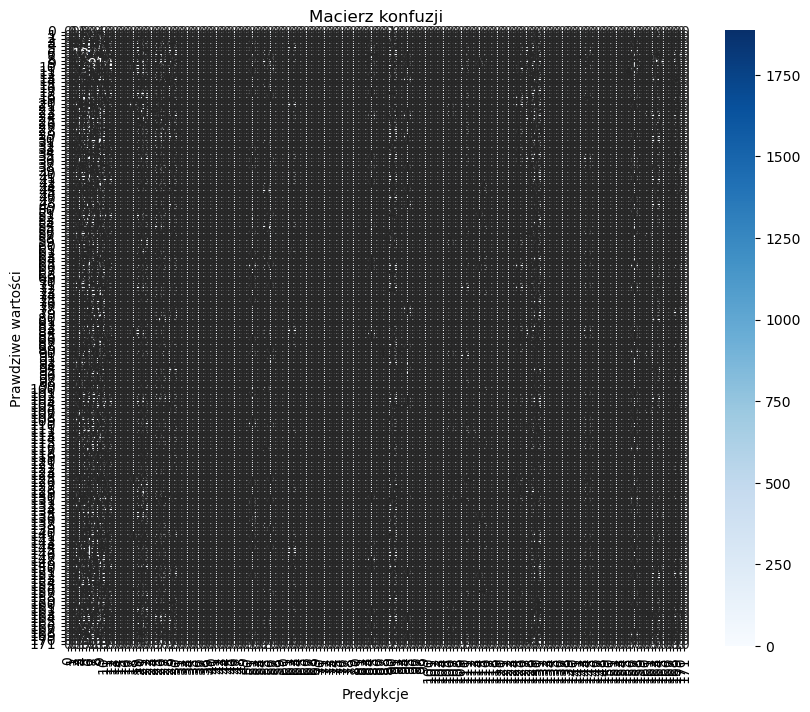

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Strata na danych testowych", test_loss)
print("Dokładność na danych testowych", test_accuracy)

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

unique_classes = np.unique(y_test_classes)
print(f"Unikalne klasy: {len(unique_classes)}")
print(f"Liczba klas w label_encoder: {len(label_encoder.classes_)}")

if len(unique_classes) != len(label_encoder.classes_):
    label_encoder.classes_ = np.array([str(i) for i in range(len(unique_classes))])

print(classification_report(y_test_classes,
                            y_pred_classes,
                            target_names=label_encoder.classes_))   

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix,
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_
            )
plt.xlabel('Predykcje')
plt.ylabel('Prawdziwe wartości')
plt.title('Macierz konfuzji')
plt.show()

# Zapisywanie Modelu
Zapisanie wytrenowanego modelu do pliku dla późniejszego wykorzystania.

- Model zapisano w formacie .h5 dla późniejszego użycia.
- Wczytany model zachowuje te same wyniki, co oryginalny.

In [32]:
model.save('../models/model_klasyfikacji_piwa.h5')

loaded_model = keras.models.load_model('../models/model_klasyfikacji_piwa.h5')

loaded_model.summary()

loaded_test_loss, loaded_test_accuracy = loaded_model.evaluate(X_test, y_test)

print(f'Loaded Test Loss: {loaded_test_loss}')
print(f'Loaded Test Accuracy: {loaded_test_accuracy}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 256)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 176)            │         5,808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,778 (210.07 KB)

 Trainable params: 52,816 (206.31 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 2 (12.00 B)

462/462 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3295 - loss: 2.7310
Loaded Test Loss: 2.733996868133545
Loaded Test Accuracy: 0.3308061957359314


In [8]:
data = pd.read_csv('../data.csv')

numeric_columns = ['Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency']
X = data[numeric_columns].copy()

X = X.fillna(X.mean())

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['Style'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

num_classes = len(np.unique(y))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

index_to_gatunek = {index: name for index, name in enumerate(label_encoder.classes_)}

def przewiduj_gatunek_piwa(dane):
    if 'model' not in globals():
        global model
        model = keras.models.load_model('../models/model_klasyfikacji_piwa.h5')
    
    dane_scaled = scaler.transform([dane])
    
    predykcja = model.predict(dane_scaled)
    gatunek_index = np.argmax(predykcja, axis=1)[0]
    gatunek = index_to_gatunek[gatunek_index]
    
    return gatunek

przykladowe_dane = [20.0, 1.050, 1.010, 5.4, 35, 10, 25.0, 60, 1.045, 75]
gatunek = przewiduj_gatunek_piwa(przykladowe_dane)
print(f'Przewidywany gatunek piwa: {gatunek}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Przewidywany gatunek piwa: American Pale Ale


d:\Anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
